In [10]:
import pandas as pd
import numpy as np
from catboost import Pool, CatBoostClassifier

In [11]:
N_CUSTOMERS_REDUCED = 5000
USE_REDUCED = False
cat_vars =  ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68'] 

In [12]:
if USE_REDUCED:
    df = pd.read_csv('train_data_reduced.csv')
    df_lab = pd.read_csv('train_labels_reduced.csv')
    df = df.drop('Unnamed: 0', axis=1)
    df_lab = df_lab.drop('Unnamed: 0', axis=1)
else:
    df = pd.read_csv('/dev/shm/train_data.csv')
    df_lab = pd.read_csv('/dev/shm/train_labels.csv')
    
# TODO let's load this l8r
# df_test = pd.read_csv('/dev/shm/test_data.csv')

### Dataset reduction (fast prototyping!)

In [4]:
# This makes no sense if we're already operating
# on a reduced dataframe.
if not USE_REDUCED:
    unique_customers = df.customer_ID.unique()
    customer_selection = np.random.choice(unique_customers, size=N_CUSTOMERS_REDUCED, replace=False)

    df = df[df.customer_ID.isin(customer_selection)]
    df_lab = df_lab[df_lab.customer_ID.isin(customer_selection)]

    df.to_csv('train_data_reduced.csv')
    df_lab.to_csv('train_labels_reduced.csv')

## Data Exploration

In [13]:
print(f'Rows per customer: {df.shape[0] / df.customer_ID.unique().shape[0]}',)

Rows per customer: 12.053376130116165


In [6]:
df_with_labels = df.set_index('customer_ID').join(df_lab.set_index('customer_ID'))

In [7]:
len(df_with_labels)

60220

### Missing Values

In [8]:
nan_per_column = df_with_labels.isna().sum()

In [9]:
nan_percentage = nan_per_column / len(df_with_labels)
nan_percentage = nan_percentage[nan_percentage != 0]

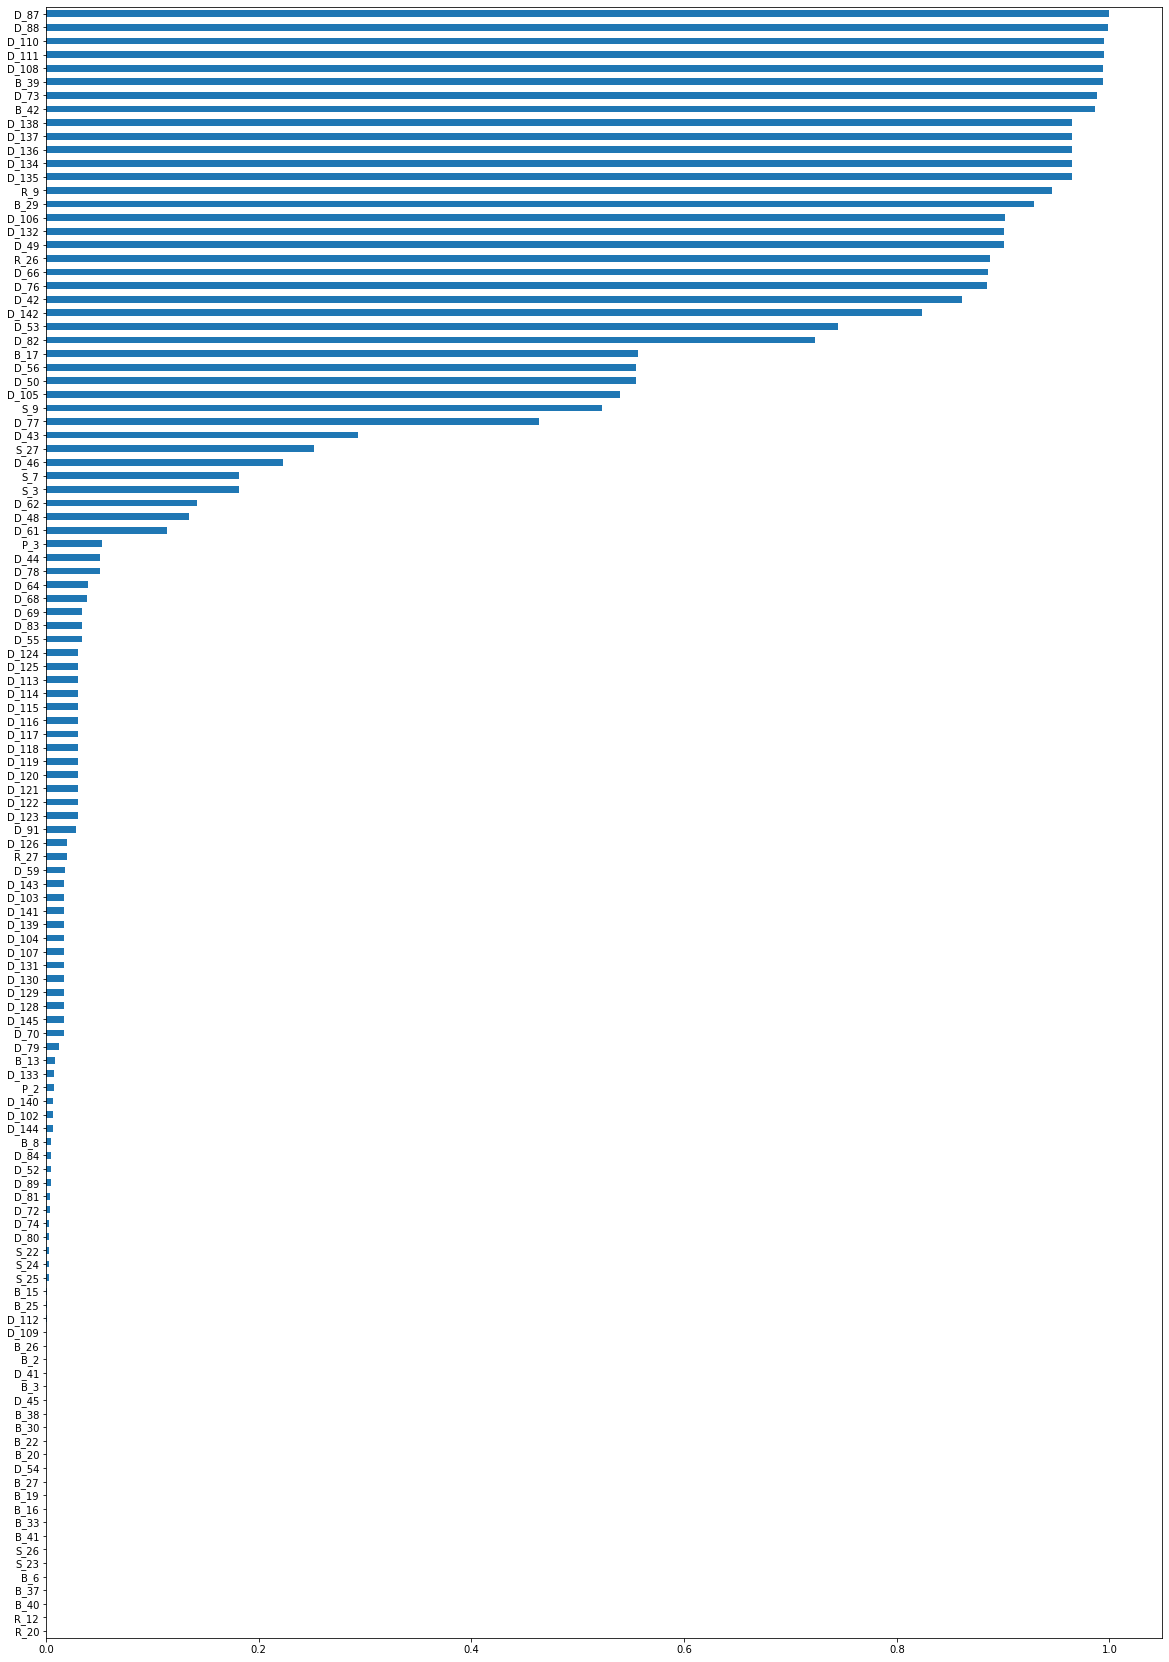

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
nan_percentage.sort_values().plot(kind='barh')
fig.set_size_inches(20, 30)

### Combine Rows into one

In [14]:
def preprocess(dataframe):
    cat_dtypes = dataframe.dtypes[cat_vars]
    dataframe[cat_vars] = dataframe[cat_vars].where(~dataframe[cat_vars].isna(), 0)

    dataframe = dataframe.astype({k: np.int32 for k in cat_dtypes[cat_dtypes == np.float64].keys()})
    #df_no_nan = df.replace(np.nan, "")
    #df_wide = dataframe.groupby('customer_ID').sum().unstack()

    df_reset = dataframe.reset_index()
    df_reset['group_index'] = dataframe.groupby('customer_ID').cumcount()
    df_reindex = df_reset.set_index(['customer_ID', 'group_index'])

    df_unstacked = df_reindex.unstack()

    df_unstacked = df_unstacked.drop('index', level=0, axis=1)
    df_unstacked = df_unstacked.drop('S_2', level=0, axis=1)

    df_unstacked.columns = [' '.join(map(str, col)).strip() for col in df_unstacked.columns.values]

    # Convert categorical features in wide dataframe to integers
    cat_vars_wide = list(filter(lambda x: any([y in x for y in cat_vars]), df_unstacked.columns))
    cat_dtypes = df_unstacked.dtypes[cat_vars_wide]

    df_unstacked = df_unstacked.astype({k: 'Int32' for k in cat_dtypes[cat_dtypes==np.float64].keys()})
    df_unstacked = df_unstacked.replace(np.nan, -1)
    cat_dtypes = df_unstacked.dtypes[cat_vars_wide]
    df_unstacked = df_unstacked.astype({k: np.int32 for k in cat_dtypes[cat_dtypes=='Int32'].keys()})
    return df_unstacked, cat_vars_wide

### Catboost

In [15]:
df_preprocessed, cat_vars_wide = preprocess(df)

In [16]:
pool = Pool(df_preprocessed, df_lab['target'], cat_vars_wide)

In [17]:
model = CatBoostClassifier(iterations=300, l2_leaf_reg=7, depth=7, learning_rate=0.1, verbose=False, task_type="GPU",)

In [18]:
model.fit(pool)

# Prediction

In [19]:
df_test = pd.read_csv('/dev/shm/test_data.csv')

In [20]:
df_test_preprocessed, cat_vars_wide = preprocess(df_test)

In [21]:
preds = model.predict_proba(df_test_preprocessed)[:,1]

In [22]:
preds

array([0.07747805, 0.00290953, 0.02803022, ..., 0.57833311, 0.37376286,
       0.14284448])

In [23]:
df_preds = df_test_preprocessed.assign(p=preds)

In [24]:
a=df_preds['p'].reset_index()

In [25]:
a.groupby('customer_ID').mean().rename(columns={"p":"prediction"}).to_csv('preds_wideframe_finetune.csv')